# The Battle of Neighborhoods (Week 1)

## 1) Introduction/Business Problem

To choose a place to open a new hotel, considering transportation data with favorite venues and competitors information on Foursquare

In [3]:
# 1. Import libraries that are needed
import numpy as np
import pandas as pd 
!pip install folium
import folium # to create map

     |████████████████████████████████| 92kB 17.0MB/s eta 0:00:01


In [4]:
#foursquare
CLIENT_ID = 'V5W4CDD1NY1CY0KIL22NCAHNKF2CZRI1YRR2FDX3ZX5XE0L1' 
CLIENT_SECRET = 'DWNADAJR4OBB05ZQLIR4QZ5CDGSAUEGOWDNJPXAVEYLMHTR3' 
VERSION = '20200414' # Foursquare API version

In [5]:
from bs4 import BeautifulSoup
import requests
raw = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(raw.text, 'lxml')
#get data from the page
data = []
columns = []
table = soup.find(class_='wikitable')
for index, tr in enumerate(table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
    
    #set header
    if (index == 0):
        columns = section
    else:
        data.append(section)

#convert to df
c_df = pd.DataFrame(data = data,columns = columns)
c_df.head()

,Postal code,Borough,Neighborhood
0,M1A,Not assigned,
1,M2A,Not assigned,
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront


In [6]:
#delete not assign
c_df = c_df[c_df['Borough'] != 'Not assigned']
c_df.head()

,Postal code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Regent Park / Harbourfront
5,M6A,North York,Lawrence Manor / Lawrence Heights
6,M7A,Downtown Toronto,Queen's Park / Ontario Provincial Government


In [7]:
#delete borough
split1 = c_df.drop('Borough',1)

#change column Postal code to post
split1.columns = ['post', 'Neighborhood']

split1.head()

,post,Neighborhood
2,M3A,Parkwoods
3,M4A,Victoria Village
4,M5A,Regent Park / Harbourfront
5,M6A,Lawrence Manor / Lawrence Heights
6,M7A,Queen's Park / Ontario Provincial Government


In [8]:
# Step 1
# Creating a new dataframe from the series with postalcode as the index
new_df = pd.DataFrame(split1.Neighborhood.str.split('/').tolist(), index=split1.post).stack()
new_df = new_df.reset_index([0, 'post'])
new_df.columns = ['post', 'Neighborhood']
new_df.head()

,post,Neighborhood
0,M3A,Parkwoods
1,M4A,Victoria Village
2,M5A,Regent Park
3,M5A,Harbourfront
4,M6A,Lawrence Manor


In [9]:
ll = pd.read_csv('https://cocl.us/Geospatial_data')
ll.columns =['PC', 'Latitude','Longitude'] 
ll.head()

,PC,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
split=new_df.join(ll.set_index('PC'), on='post')
split.columns=['Post', 'Neighborhood', 'Latitude', 'Longitude'] 
split.head()

,Post,Neighborhood,Latitude,Longitude
0,M3A,Parkwoods,43.753259,-79.329656
1,M4A,Victoria Village,43.725882,-79.315572
2,M5A,Regent Park,43.654260,-79.360636
3,M5A,Harbourfront,43.654260,-79.360636
4,M6A,Lawrence Manor,43.718518,-79.464763


In [11]:
b = c_df.drop('Neighborhood',1)
b.head()

,Postal code,Borough
2,M3A,North York
3,M4A,North York
4,M5A,Downtown Toronto
5,M6A,North York
6,M7A,Downtown Toronto


In [12]:
final = split.join(b.set_index('Postal code'),on='Post')
final.columns=['Postalcode', 'Neighborhood', 'Latitude', 'Longitude','Borough'] 
final.sort_values(by=['Neighborhood'], inplace=True)
final.head()

,Postalcode,Neighborhood,Latitude,Longitude,Borough
49,M5H,Adelaide,43.650571,-79.384568,Downtown Toronto
152,M1V,Agincourt North,43.815252,-79.284577,Scarborough
177,M9V,Albion Gardens,43.739416,-79.588437,Etobicoke
164,M5V,Bathurst\n Quay,43.628947,-79.394420,Downtown Toronto
175,M9V,Beaumond Heights,43.739416,-79.588437,Etobicoke


In [58]:
final.shape

(208, 5)

In [13]:
# get top 5 hotels around neighborhood St. James Town in Downtown Toronto

LIMIT = 5
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&query=hotel'.format(CLIENT_ID, CLIENT_SECRET, 43.651494, -79.375418, VERSION, radius, LIMIT)

hotels = requests.get(url).json()
hotels

{'meta': {'code': 200, 'requestId': '5e983e9740a7ea001bb95a48'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'St. Lawrence',
  'headerFullLocation': 'St. Lawrence, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'query': 'hotel',
  'totalResults': 17,
  'suggestedBounds': {'ne': {'lat': 43.6559940045, 'lng': -79.36921028605637},
   'sw': {'lat': 43.6469939955, 'lng': -79.38162571394362}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adf7d0bf964a520127b21e3',
       'name': 'The Omni King Edward Hotel',
       'location': {'address': '37 King Street East',
        'crossStreet': 'bwtn Victoria St. and Toronto St.',
        'lat': 43.64919051601911,
        'lng': -

In [14]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [15]:
import json # library of JSON file
from pandas.io.json import json_normalize # tranform JSON file

hotels1 = hotels['response']['groups'][0]['items']  
nearbyhotels = json_normalize(hotels1) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearbyhotels =nearbyhotels.loc[:, filtered_columns]

# clean category
nearbyhotels['venue.categories'] = nearbyhotels.apply(get_category_type, axis=1)

# clean columns
nearbyhotels.columns = [col.split(".")[-1] for col in nearbyhotels.columns]

nearbyhotels.head()

,name,categories,lat,lng
0,The Omni King Edward Hotel,Hotel,43.649191,-79.376006
1,Cambridge Suites Toronto,Hotel,43.651836,-79.378107
2,Cosmopolitan Toronto Centre Hotel & Spa,Hotel,43.649064,-79.377598
3,HI-Toronto Hostel,Hostel,43.650623,-79.375190
4,One King West Hotel & Residence,Hotel,43.649139,-79.377876


In [16]:
#get hotels list in toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&query=hotel'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_hotels = getNearbyVenues(names=final['Neighborhood'],
                                   latitudes=final['Latitude'],
                                   longitudes=final['Longitude'])
toronto_hotels.head()

 Adelaide 
 Agincourt North 
 Albion Gardens
 Bathurst
 Quay 
 Beaumond Heights 
 Bloordale Gardens 
 Cabbagetown
 Chinatown 
 Clairlea 
 Cliffcrest 
 Cliffside West
 Cloverdale
 Deer Park
 Design Exchange
 Dovercourt Village
 Downsview North
 East Birchmount Park
 Emery
 Exhibition Place
 Forest Hill SE 
 Grange Park
 Harbord
 Harbourfront
 Harbourfront West 
 Henry Farm 
 Highland Creek
 Humber Bay 
 Humber Bay Shores
 Humbergate 
 Ionview 
 Island airport
 Islington 
 Jamestown 
 Keelsdale and Silverthorn
 King
 King and Spadina 
 King's Mill Park 
 Kingsway Park South East
 Kingsway Park South West 
 L'Amoreaux East
 L'Amoreaux West
 Lawrence Heights
 Lawrence Manor East
 Long Branch
 Maple Leaf Park 
 Markland Wood
 Martin Grove 
 Martin Grove Gardens 
 Maryvale
 Mimico NE 
 Mimico South 
 Montgomery Road  
 Morningside 
 Mount Dennis 
 Mount Olive 
 Newtonbrook
 North Midtown 
 Oakridge
 Old Burnhamthorpe 
 Old Mill North
 Ontario Provincial Government
 Oriole
 Parkdale Village 


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adelaide,43.650571,-79.384568,Shangri-La Toronto,43.649129,-79.386557,Hotel
1,Adelaide,43.650571,-79.384568,Hilton,43.649946,-79.385479,Hotel
2,Adelaide,43.650571,-79.384568,Sheraton Centre Toronto Hotel,43.650594,-79.384530,Hotel
3,Adelaide,43.650571,-79.384568,The Rex Hotel Jazz & Blues Bar,43.650505,-79.388577,Jazz Club
4,Adelaide,43.650571,-79.384568,DoubleTree by Hilton,43.654608,-79.385942,Hotel


In [17]:
counthotel= pd.DataFrame(toronto_hotels.groupby('Neighborhood').count())
counthotel.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Adelaide,5,5,5,5,5,5
Chinatown,5,5,5,5,5,5
Design Exchange,5,5,5,5,5,5
Grange Park,5,5,5,5,5,5
Harbourfront,2,2,2,2,2,2


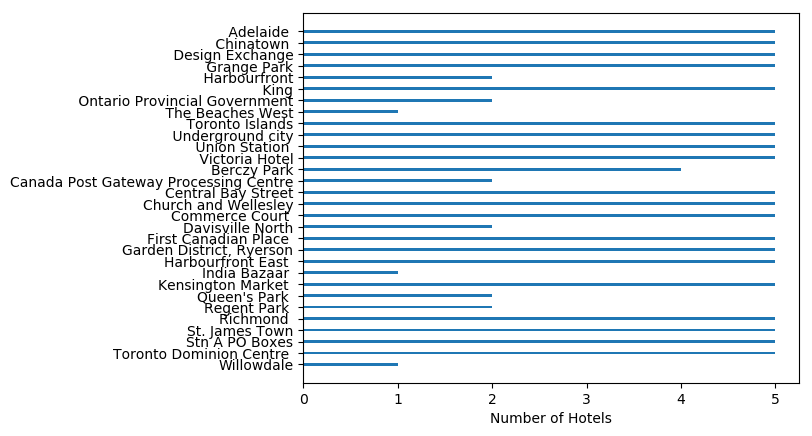

In [42]:
import matplotlib.pyplot as plt
# Fixing random state for reproducibility
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()

x = counthotel['Venue']
y = counthotel.index

ax.barh(y, x,height=0.25,align='center')
ax.set_yticks(y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Hotels')

plt.show()

In [26]:
potentialneighborhood=counthotel.loc[counthotel['Venue']<5]
potentialneighborhood

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Harbourfront,2,2,2,2,2,2
Ontario Provincial Government,2,2,2,2,2,2
The Beaches West,1,1,1,1,1,1
Berczy Park,4,4,4,4,4,4
Canada Post Gateway Processing Centre,2,2,2,2,2,2
Davisville North,2,2,2,2,2,2
India Bazaar,1,1,1,1,1,1
Queen's Park,2,2,2,2,2,2
Regent Park,2,2,2,2,2,2


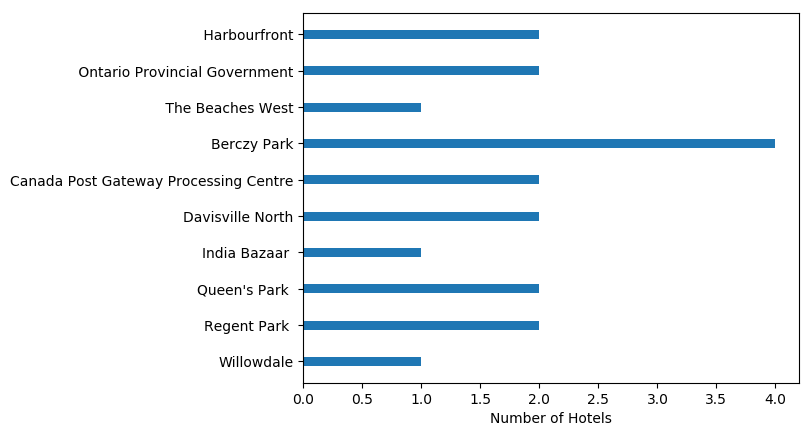

In [43]:
# Fixing random state for reproducibility
np.random.seed(19680801)
plt.rcdefaults()
fig, ax = plt.subplots()

x = potentialneighborhood['Venue']
y = potentialneighborhood.index

ax.barh(y, x,height=0.25,align='center')
ax.set_yticks(y)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Hotels')

plt.show()

In [45]:
potentials = potentialneighborhood.drop('Neighborhood Latitude',1)
potentials = potentials.drop ('Neighborhood Longitude',1)
potentials = potentials.drop ('Venue Latitude',1)
potentials = potentials.drop ('Venue Longitude',1)
potentials = potentials.drop ('Venue Category',1)
potentials.head()

,Venue
Neighborhood,
Harbourfront,2
Ontario Provincial Government,2
The Beaches West,1
Berczy Park,4
Canada Post Gateway Processing Centre,2


In [46]:
ll = final.drop('Postalcode',1)
ll = ll.drop('Borough',1)
area=potentials.join(ll.set_index('Neighborhood'),on='Neighborhood')
area.columns=['Venue', 'Latitude', 'Longitude'] 
area.reset_index() # reset the index
# this is the area with shortage tourism supply and their location

,Neighborhood,Venue,Latitude,Longitude
0,Harbourfront,2,43.654260,-79.360636
1,Ontario Provincial Government,2,43.662301,-79.389494
2,The Beaches West,1,43.668999,-79.315572
3,Berczy Park,4,43.644771,-79.373306
4,Canada Post Gateway Processing Centre,2,43.636966,-79.615819
5,Davisville North,2,43.712751,-79.390197
6,India Bazaar,1,43.668999,-79.315572
7,Queen's Park,2,43.662301,-79.389494
8,Regent Park,2,43.654260,-79.360636
9,Willowdale,1,43.770120,-79.408493


In [47]:
n = area.drop('Venue',1)
n=n.reset_index()
n.head()

,Neighborhood,Latitude,Longitude
0,Harbourfront,43.654260,-79.360636
1,Ontario Provincial Government,43.662301,-79.389494
2,The Beaches West,43.668999,-79.315572
3,Berczy Park,43.644771,-79.373306
4,Canada Post Gateway Processing Centre,43.636966,-79.615819


In [48]:
neighborhood_latitude = n.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = n.loc[0, 'Longitude'] # neighborhood longitude value

In [49]:
LIMIT = 10 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Roselle Desserts,Bakery,43.653447,-79.362017
1,Tandem Coffee,Coffee Shop,43.653559,-79.361809
2,Cooper Koo Family YMCA,Distribution Center,43.653249,-79.358008
3,Body Blitz Spa East,Spa,43.654735,-79.359874
4,Morning Glory Cafe,Breakfast Spot,43.653947,-79.361149
5,Impact Kitchen,Restaurant,43.656369,-79.356980
6,Corktown Common,Park,43.655618,-79.356211
7,Figs Breakfast & Lunch,Breakfast Spot,43.655675,-79.364503
8,The Distillery Historic District,Historic Site,43.650244,-79.359323
9,Dominion Pub and Kitchen,Pub,43.656919,-79.358967


In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [60]:
potential_venues = getNearbyVenues(names=n['Neighborhood'],
                                   latitudes=n['Latitude'],
                                   longitudes=n['Longitude']
                                  )
potential_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [66]:
picks=potential_venues.groupby('Neighborhood').count()
picks = picks.reset_index()
picks

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,10,10,10,10,10,10
1,Ontario Provincial Government,10,10,10,10,10,10
2,The Beaches West,10,10,10,10,10,10
3,Berczy Park,10,10,10,10,10,10
4,Canada Post Gateway Processing Centre,10,10,10,10,10,10
5,Davisville North,8,8,8,8,8,8
6,India Bazaar,10,10,10,10,10,10
7,Queen's Park,10,10,10,10,10,10
8,Regent Park,10,10,10,10,10,10
9,Willowdale,15,15,15,15,15,15


In [69]:
print('There are {} uniques categories.'.format(len(potential_venues['Venue Category'].unique())))

There are 50 uniques categories.


In [70]:
# onehot --> oh
dt_oh = pd.get_dummies(potential_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column
dt_oh['Neighborhood'] = potential_venues['Neighborhood']

# neighborhood column --> 1st column
fixed_columns = [dt_oh.columns[-1]] + list(dt_oh.columns[:-1])
dt_oh = dt_oh[fixed_columns]

dt_oh.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Bakery,Bank,Beer Bar,Breakfast Spot,Brewery,Burrito Place,Butcher,...,Plaza,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Spa,Steakhouse,Sushi Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio
0,Harbourfront,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Harbourfront,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Harbourfront,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
dt_grouped = dt_oh.groupby('Neighborhood').mean().reset_index()
dt_grouped.head()

,Neighborhood,American Restaurant,Arts & Crafts Store,Bakery,Bank,Beer Bar,Breakfast Spot,Brewery,Burrito Place,Butcher,...,Plaza,Pub,Ramen Restaurant,Restaurant,Sandwich Place,Spa,Steakhouse,Sushi Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio
0,Harbourfront,0.0,0.0,0.1,0.0,0.0,0.2,0.0,0.0,0.0,...,0.0,0.1,0.0,0.1,0.0,0.1,0.0,0.0,0.0,0.0
1,Ontario Provincial Government,0.0,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1
2,The Beaches West,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0
3,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.0
4,Canada Post Gateway Processing Centre,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0


In [72]:
#get top 3 venues per neighborhood
num_top_venues = 3
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

indicators = ['st', 'nd', 'rd']

# create top venues column
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nb_venues = pd.DataFrame(columns=columns)
nb_venues['Neighborhood'] = dt_grouped['Neighborhood']

for ind in np.arange(dt_grouped.shape[0]):
    nb_venues.iloc[ind, 1:] = return_most_common_venues(dt_grouped.iloc[ind, :], num_top_venues)

nb_venues

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Harbourfront,Breakfast Spot,Pub,Restaurant
1,Ontario Provincial Government,Coffee Shop,Park,Italian Restaurant
2,The Beaches West,Gym,Sushi Restaurant,Fish & Chips Shop
3,Berczy Park,Museum,Concert Hall,Vegetarian / Vegan Restaurant
4,Canada Post Gateway Processing Centre,Coffee Shop,Hotel,Burrito Place
5,Davisville North,Gym,Food & Drink Shop,Hotel
6,India Bazaar,Gym,Sushi Restaurant,Fish & Chips Shop
7,Queen's Park,Coffee Shop,Park,Italian Restaurant
8,Regent Park,Breakfast Spot,Pub,Restaurant
9,Willowdale,Coffee Shop,Café,Japanese Restaurant


In [73]:
#K-means clustering into 5 groups

# import k-means
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

dt_grouped_clustering = dt_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dt_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 3, 2, 0, 4, 1, 2, 3, 1, 0], dtype=int32)

In [74]:
nb_venues.insert(1,'Cluster', kmeans.labels_)
nb_venues.head()

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Harbourfront,1,Breakfast Spot,Pub,Restaurant
1,Ontario Provincial Government,3,Coffee Shop,Park,Italian Restaurant
2,The Beaches West,2,Gym,Sushi Restaurant,Fish & Chips Shop
3,Berczy Park,0,Museum,Concert Hall,Vegetarian / Vegan Restaurant
4,Canada Post Gateway Processing Centre,4,Coffee Shop,Hotel,Burrito Place


In [79]:
nb_venues

,Neighborhood,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Harbourfront,1,Breakfast Spot,Pub,Restaurant
1,Ontario Provincial Government,3,Coffee Shop,Park,Italian Restaurant
2,The Beaches West,2,Gym,Sushi Restaurant,Fish & Chips Shop
3,Berczy Park,0,Museum,Concert Hall,Vegetarian / Vegan Restaurant
4,Canada Post Gateway Processing Centre,4,Coffee Shop,Hotel,Burrito Place
5,Davisville North,1,Gym,Food & Drink Shop,Hotel
6,India Bazaar,2,Gym,Sushi Restaurant,Fish & Chips Shop
7,Queen's Park,3,Coffee Shop,Park,Italian Restaurant
8,Regent Park,1,Breakfast Spot,Pub,Restaurant
9,Willowdale,0,Coffee Shop,Café,Japanese Restaurant


NameError: name 'downtown' is not defined

In [55]:
picks = picks.drop('Neighborhood Latitude',1)
picks = picks.drop('Neighborhood Longitude',1)
picks = picks.drop('Venue Latitude',1)
picks = picks.drop('Venue Longitude',1)
picks = picks.drop('Venue',1)
picks = picks.reset_index()
picks

,Neighborhood,Venue Category
0,Harbourfront,10
1,Ontario Provincial Government,10
2,The Beaches West,10
3,Berczy Park,10
4,Canada Post Gateway Processing Centre,10
5,Davisville North,8
6,India Bazaar,10
7,Queen's Park,10
8,Regent Park,10
9,Willowdale,15


In [231]:
potentials = potentials.reset_index()
choice = picks.join(potentials.set_index('Neighborhood'),on='Neighborhood')
choice.columns=['Neighborhood', 'Other categories', 'Hotel Number'] 
choice

,Neighborhood,Other categories,Hotel Number
0,Harbourfront,10,2
1,Ontario Provincial Government,10,2
2,The Beaches West,10,1
3,Berczy Park,10,4
4,Canada Post Gateway Processing Centre,10,2
5,Davisville North,8,2
6,India Bazaar,10,1
7,Queen's Park,10,2
8,Regent Park,10,2
9,Willowdale,17,1


In [232]:
# Choose the neighborhood with limited hotel numbers and most other categories --> Willowdale / The Beaches West